In [29]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error

import multiprocessing
NUM_CORES = multiprocessing.cpu_count()

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import optuna
import unicodedata

import lightgbm as lgb

In [30]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    seed = 42
    #seed = 2023
    #seed = 1111
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    target_bins = 20
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"

In [31]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [32]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train_embeddings = pd.read_csv(CFG.data_dir+"train_embeddings.csv")
test_embeddings = pd.read_csv(CFG.data_dir+"test_embeddings.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [33]:
# ===================================================================
#  preprocessing
# ===================================================================
# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df
all_data = pre_year(all_data)

# manufacturer
all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
manufacturer_map = {
    'niѕsan':'nissan',
    'nisѕan':'nissan',
    'subαru':'subaru',
    'toyotа':'toyota',
    'sαturn':'saturn',
    'аcura':'acura',
    'vоlkswagen':'volkswagen',
    'lexuѕ':'lexus',
    'ᴄhrysler':'chrysler',
}
all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)

# fuel
## 欠損値 train: 1239, test, 1495 
## わざと欠損値にしている訳ではなさそう？
all_data["fuel"].fillna(value="Unknown", inplace=True)


# odometer
## 後でvalidationを作るときに直そう

# title_status
## 欠損値 train: 456, test: 229
all_data["title_status"].fillna(value="Unknown", inplace=True)

# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df
all_data = pre_size(all_data)

# type
## 欠損値 train: 456, test: 229
all_data["type"].fillna(value="Unknown", inplace=True)


# state
## 欠損値 train: 3304, test: 3029
all_data["state"].fillna(value="Unknown", inplace=True)

In [34]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=20, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(skf.split(X=train, y=train["price_map"])):
    train.loc[val, "fold"] = i
print(train["fold"].value_counts())
print(train.groupby("fold")["price"].mean().std())

fold
1.0    5507
0.0    5507
2.0    5506
4.0    5506
3.0    5506
Name: count, dtype: int64
8.784566908616718


In [35]:
# ===================================================================
#  Variance by category
# ===================================================================
all_data = pd.concat([train, test], ignore_index=True)
tmp_ = ['region',  'manufacturer', 'condition', 'cylinders',
       'fuel',  'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state',  'year_map',]
df = all_data[(all_data["odometer"] > 100)&(all_data["odometer"] < 400000)].reset_index(drop=True)
tmp = []
for col in tmp_:
    tmp.append(df.groupby(col)["odometer"].mean().std())
df = pd.DataFrame(zip(tmp_, tmp, [len(train[col].unique()) for col in tmp_]), columns=["feature", "std", "len"],)
display(df.sort_values("std", ascending=False, ignore_index=True))

,feature,std,len
0,year_map,33400.067098,20
1,condition,26899.720306,6
2,fuel,19292.666186,6
3,region,17761.052586,372
4,manufacturer,16545.615833,37
5,paint_color,16320.395312,12
6,type,16318.821524,14
7,cylinders,13385.064899,8
8,drive,12651.327741,3
9,title_status,11325.772185,7


In [36]:
train = pd.merge(train, train_embeddings, on="id", how="left")
test = pd.merge(test, test_embeddings, on="id", how="left")

In [37]:
embeddings_col = [col for col in train.columns.tolist() if col.startswith("embedding_")]

In [38]:
train.columns.tolist()

['id',
 'region',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state',
 'price',
 'flag',
 'year_map',
 'price_map',
 'fold',
 'embedding_0',
 'embedding_1',
 'embedding_2',
 'embedding_3',
 'embedding_4',
 'embedding_5',
 'embedding_6',
 'embedding_7',
 'embedding_8',
 'embedding_9',
 'embedding_10',
 'embedding_11',
 'embedding_12',
 'embedding_13',
 'embedding_14',
 'embedding_15',
 'embedding_16',
 'embedding_17',
 'embedding_18',
 'embedding_19',
 'embedding_20',
 'embedding_21',
 'embedding_22',
 'embedding_23',
 'embedding_24',
 'embedding_25',
 'embedding_26',
 'embedding_27',
 'embedding_28',
 'embedding_29',
 'embedding_30',
 'embedding_31',
 'embedding_32',
 'embedding_33',
 'embedding_34',
 'embedding_35',
 'embedding_36',
 'embedding_37',
 'embedding_38',
 'embedding_39',
 'embedding_40',
 'embedding_41',
 'embedding_42',
 'embedding_43',
 'embedding_44',
 'embedd

In [39]:
# ===================================================================
#  use features
# =================================================================== 
## numerical
CFG.numerical_features = ['year', "odometer"] + embeddings_col

## category
CFG.categorical_features = [
     'region',
    'manufacturer',
    'condition',
    'cylinders',
    'fuel',
    'title_status',
    'transmission',
    'drive',
    'size',
    'type',
    'paint_color',
    'state',
                           ]
CFG.target_encoding_features = []
CFG.count_encoding_features = []
CFG.max_encoding_features = []
CFG.std_encoding_features = []
CFG.min_encoding_features = []
CFG.median_encoding_features = []


## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [40]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    test_df = test.copy()
    
    # odometerの補正
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["year_map"])["odometer"].mean().reset_index()
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame):
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="year_map", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    test_df = replace_odometer(test_df, fillna_map)
    
    
    """
    def add_odometer_per_year(df: pd.DataFrame):
        df["elapsed_year"] = 2023 - df["year"]
        df["odometer_per_year"] = df["odometer"] / df["elapsed_year"]
        return df
    X_train = add_odometer_per_year(X_train)
    X_valid = add_odometer_per_year(X_valid) 
    test_df = add_odometer_per_year(test_df)
    """
        
    # CFG.target_encoding_features
    for col in CFG.target_encoding_features:
        mean_map = X_train.groupby(col)["price"].mean()
        X_train[col+"_target_encoding"] = X_train[col].map(mean_map)
        X_valid[col+"_target_encoding"] = X_valid[col].map(mean_map)
        test_df[col+"_target_encoding"] = test_df[col].map(mean_map)
        if fold == 0:
            CFG.use_features.append(col+"_target_encoding")
            
        
    # CFG.count_encoding_features
    for col in CFG.count_encoding_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        test_df[col+"_count_encoding"] = test_df[col].map(count_map)
        if fold == 0:
            CFG.use_features.append(col+"_count_encoding")
            
    
    # CFG.max_encoding_features
    for col in CFG.max_encoding_features:
        max_map = X_train.groupby(col)["price"].max()
        X_train[col+"_max_encoding"] = X_train[col].map(max_map)
        X_valid[col+"_max_encoding"] = X_valid[col].map(max_map)
        test_df[col+"_max_encoding"] = test_df[col].map(max_map)
        if fold == 0:
            CFG.use_features.append(col+"_max_encoding")
            
            
    # CFG.min_encoding_features
    for col in CFG.min_encoding_features:
        min_map = X_train.groupby(col)["price"].min()
        X_train[col+"_min_encoding"] = X_train[col].map(min_map)
        X_valid[col+"_min_encoding"] = X_valid[col].map(min_map)
        test_df[col+"_min_encoding"] = test_df[col].map(min_map)
        if fold == 0:
            CFG.use_features.append(col+"_min_encoding")
            
            
    # CFG.std_encoding_features
    for col in CFG.std_encoding_features:
        std_map = X_train.groupby(col)["price"].std()
        X_train[col+"_std_encoding"] = X_train[col].map(std_map)
        X_valid[col+"_std_encoding"] = X_valid[col].map(std_map)
        test_df[col+"_std_encoding"] = test_df[col].map(std_map)
        if fold == 0:
            CFG.use_features.append(col+"_std_encoding")
            
    
    # CFG.median_encoding_features
    for col in CFG.median_encoding_features:
        median_map = X_train.groupby(col)["price"].median()
        X_train[col+"_median_encoding"] = X_train[col].map(median_map)
        X_valid[col+"_median_encoding"] = X_valid[col].map(median_map)
        test_df[col+"_median_encoding"] = test_df[col].map(median_map)
        if fold == 0:
            CFG.use_features.append(col+"_median_encoding")
    
    
    # CFG.categorical_featuresをcategory型に変換
    for col in CFG.categorical_features:
        X_train[col] = X_train[col].astype("category")
        X_valid[col] = X_valid[col].astype("category")
        test_df[col] = test_df[col].astype("category")
        
        
    # params
    """
    lgb_param = {
        "task":"train",
        "objective": "mape",
        "boosting":"gbdt",
        "num_iterations": CFG.num_boost_round,
        "learning_rate":0.1, # default: 0.1
        "num_leaves":31, # max number of leaves in one tree ###
        "max_depth":4, # default -1, int: limit the max depth for tree model ###
        "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
        "min_data_in_leaf":20, # minimal number of data in one leaf
        "alpha":0.9, # double, constraints, alpha > 0.0: 
        "colsample_bytree":1.0, # 0 < "colsample_bytree" < 1
        #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
        "lambda": 0, #lambda_l2 >= 0.0: L2 regularization
        "subsample":1, #0.0 < bagging_fraction <= 1.0
        "num_threads":1,
        "metric": 'mape',
        "seed" : CFG.seed,
        "verbosity": -1,   
    }
    """
    lgb_param = {
        "task":"train",
        "objective": "mape",
        "boosting":"gbdt",
        "num_iterations": CFG.num_boost_round,
        "learning_rate":0.1, 
        "num_leaves":97,
        "max_depth":5,
        "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
        "min_data_in_leaf":81, # minimal number of data in one leaf
        "alpha":3.0259790706186402, # double, constraints, alpha > 0.0: 
        "colsample_bytree":0.22199279683162915, # 0 < "colsample_bytree" < 1
        #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
        "lambda": 7.646516124349529, #lambda_l2 >= 0.0: L2 regularization
        "subsample": 1, #0.0 < bagging_fraction <= 1.0
        "num_threads": NUM_CORES,
        'feature_fraction': 0.4670722972795847,
         'bagging_fraction': 0.98728869364854,
        'bagging_freq': 3,
        "metric": 'mape',
        "seed" : CFG.seed,
        "verbosity": -1,   
    }

    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

fold0: 45.47986865646082
fold1: 46.09604306537262
fold2: 45.04114463787647
fold3: 45.152066477005
fold4: 45.09779559384551
====== CV score ======
45.37341380177203


fold0: 44.81489170450998  
fold1: 45.365720502207544  
fold2: 44.12319504793524  
fold3: 44.57536168304539  
fold4: 44.21629776089228  
====== CV score ======  
44.61912756990577  

In [41]:
CFG.use_features

['embedding_215',
 'embedding_18',
 'embedding_2',
 'embedding_27',
 'embedding_355',
 'embedding_53',
 'embedding_276',
 'embedding_376',
 'embedding_5',
 'embedding_223',
 'embedding_317',
 'embedding_289',
 'embedding_132',
 'embedding_78',
 'embedding_138',
 'embedding_167',
 'embedding_198',
 'embedding_296',
 'embedding_250',
 'embedding_205',
 'embedding_121',
 'embedding_277',
 'embedding_33',
 'embedding_210',
 'embedding_290',
 'embedding_327',
 'embedding_148',
 'embedding_339',
 'embedding_353',
 'cylinders',
 'embedding_362',
 'embedding_124',
 'embedding_182',
 'embedding_349',
 'embedding_90',
 'embedding_6',
 'embedding_157',
 'embedding_136',
 'embedding_49',
 'embedding_67',
 'embedding_188',
 'embedding_247',
 'embedding_254',
 'embedding_139',
 'embedding_86',
 'embedding_129',
 'embedding_96',
 'embedding_181',
 'embedding_80',
 'embedding_358',
 'embedding_287',
 'embedding_328',
 'embedding_368',
 'embedding_99',
 'embedding_273',
 'embedding_193',
 'embedding_28

In [42]:
len(CFG.use_features)

398

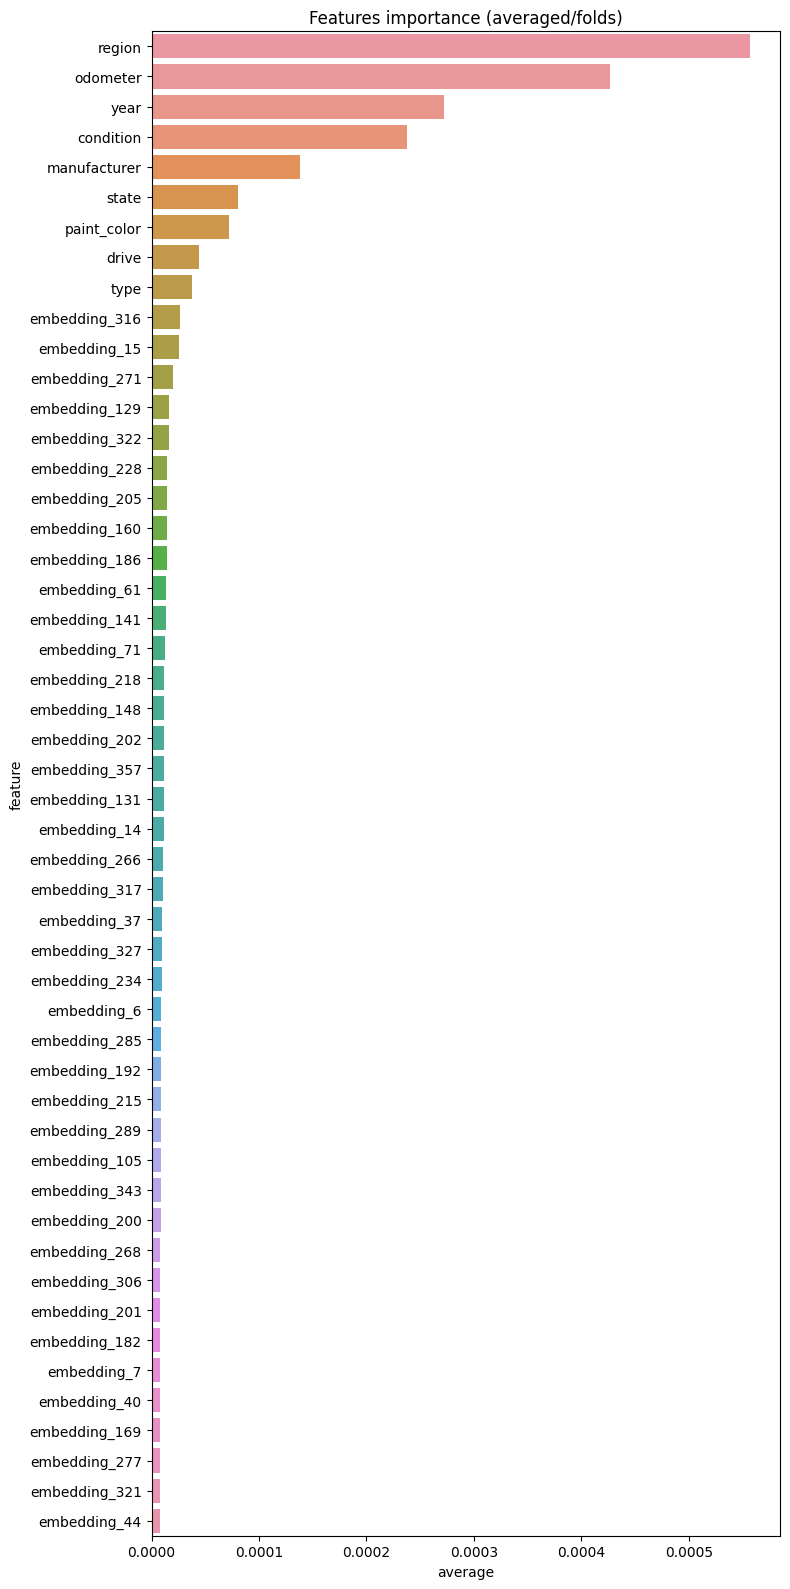

In [43]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [44]:
# ===================================================================
#  optuna
# ===================================================================
def objective(trial):
    a = trial.suggest_float("a", 0, 1)
    
    oof_df[f"pred_1"] = oof_df[f"pred"] * a
    score = get_score(y_true=oof_df["price"], y_pred = oof_df[f"pred_1"])
    return score
    
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=CFG.seed))
study.optimize(objective, 
                n_trials=CFG.n_trials,
                show_progress_bar=True)

best_params = study.best_params
best_value = study.best_value
print(best_params, best_value)

Best trial: 109. Best value: 45.3633: 100%|██████████| 1500/1500 [00:29<00:00, 50.65it/s]

{'a': 0.9872051599987991} 45.363264344859786


In [45]:
# ===================================================================
#  prediction
# ===================================================================
test["pred"] = predictions * best_params["a"]
print(test["pred"].min(), test["pred"].max())
test[["id", "pred"]].to_csv(CFG.save_dir+"exp005.csv", index=False, header=None)

1447.7145338009616 25847.92378090693
